In [2]:
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from matplotlib.colors import BoundaryNorm
from numpy.typing import NDArray
from rasterio.windows import from_bounds
from scipy.cluster.hierarchy import DisjointSet
from tqdm import tqdm

In [4]:
SUFOSAT_START_DATE = pd.Timestamp(year=2014, month=4, day=3)
MAX_METERS_BETWEEN_CLEAR_CUTS = 50
MAX_DAYS_BETWEEN_CLEAR_CUTS = 7 * 4

## Explore the clear cut probabilties file

The minimum probability from `mosaics_tropisco_warnings_france_prob.tif` is 89%.
I think we can safely ignore this probability file.


In [220]:
def explore_probabilities() -> None:
    """
    This function describes the SUFOSAT clear cuts probabilities
    """
    probas = []
    with rasterio.open("../data/sufosat/mosaics_tropisco_warnings_france_prob.tif") as src:
        # Read the data as a generator (window-by-window) to avoid out Of memory issues
        # since the total grid contains billions of points
        for _, window in tqdm(
            src.block_windows(),
            total=src.width * src.height // (src.block_shapes[0][0] * src.block_shapes[0][1]),
        ):
            # Read the block data for the first and only band
            data = src.read(1, window=window)

            # Ignore the block if it contains no data
            if np.all(data == src.nodata):
                continue

            data_probas = data.flatten()
            data_probas = data_probas[data_probas != 0]
            probas.append(data_probas)

    # Show probabilities statistics
    display(pd.Series(np.concatenate(probas)).describe().astype(int))


explore_probabilities()

  0%|          | 0/15370 [00:00<?, ?it/s]

15458it [00:51, 302.68it/s]                           


count    40077177
mean           97
std             2
min            89
25%            96
50%            99
75%           100
max           100
dtype: int64

## Vectorize SUFOSAT raster


In [54]:
!mkdir ../data/sufosat/sufosat/
!gdal_polygonize.py -8 ../data/sufosat/mosaics_tropisco_warnings_france_date.tif ../data/sufosat/sufosat/sufosat.shp

Creating output ../data/sufosat/sufosat/sufosat.shp of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.
free(): invalid pointer


## Cluster clear cuts by space and time

Clear cuts that are less than X meters and Y days apart should be grouped as single clear cuts.


### Geopandas spatial join


In [10]:
gdf: gpd.GeoDataFrame = gpd.read_file("../data/sufosat/sufosat/sufosat.shp")
gdf["date"] = SUFOSAT_START_DATE + pd.to_timedelta(gdf["DN"], unit="D")
gdf = gdf.drop(columns="DN")
gdf

,geometry,date
0,"POLYGON ((3.87689 51.44783, 3.87785 51.44783, ...",2020-04-11
1,"POLYGON ((3.87785 51.44783, 3.87796 51.44783, ...",2022-04-01
2,"POLYGON ((3.87796 51.44783, 3.87832 51.44783, ...",2022-03-20
3,"POLYGON ((3.87761 51.44774, 3.87796 51.44774, ...",2020-03-30
4,"POLYGON ((3.87856 51.44774, 3.87868 51.44774, ...",2022-04-25
...,...,...
5920292,"POLYGON ((9.25654 41.09792, 9.25666 41.09792, ...",2022-07-31
5920293,"POLYGON ((9.2563 41.09783, 9.25642 41.09783, 9...",2022-02-07
5920294,"POLYGON ((9.25642 41.09783, 9.25654 41.09783, ...",2021-12-09
5920295,"POLYGON ((9.25654 41.09783, 9.25666 41.09783, ...",2022-02-13


The number of polygons is huge and it will take some time to cluster. Therefore, for the moment, we only process the recent data, since 2024.


In [11]:
gdf: gpd.GeoDataFrame = gdf[gdf["date"] >= pd.Timestamp(year=2024, month=1, day=1)]
gdf

,geometry,date
237,"POLYGON ((3.80855 51.44248, 3.80879 51.44248, ...",2024-05-05
241,"POLYGON ((3.80831 51.44239, 3.80843 51.44239, ...",2024-05-05
298,"POLYGON ((3.80891 51.44157, 3.80903 51.44157, ...",2024-04-11
867,"POLYGON ((3.84416 51.42064, 3.84428 51.42064, ...",2024-05-29
894,"POLYGON ((3.84775 51.42046, 3.84787 51.42046, ...",2024-06-22
...,...,...
5920272,"POLYGON ((9.43938 41.09983, 9.43962 41.09983, ...",2024-05-15
5920273,"POLYGON ((9.43962 41.09974, 9.43974 41.09974, ...",2024-06-02
5920274,"POLYGON ((9.43974 41.09974, 9.43986 41.09974, ...",2024-06-14
5920276,"POLYGON ((9.43914 41.09964, 9.43962 41.09964, ...",2024-05-27


We want to group the clear-cuts that are less than 50 meters apart.
To achieve this, we will perform a spatial join.
Before joining, we will buffer each polygon by 25 meters.


In [12]:
# Reproject into a coordinate system with meters as units (Lambert-93)
gdf = gdf.to_crs(epsg=2154)
# Buffer each clear cut by half the max distance between clear cuts
gdf["buffered"] = gdf.geometry.buffer(MAX_METERS_BETWEEN_CLEAR_CUTS / 2)
gdf

,geometry,date,buffered
237,"POLYGON ((756376.416 7150104.527, 756393.134 7...",2024-05-05,"POLYGON ((756351.417 7150104.271, 756351.513 7..."
241,"POLYGON ((756359.801 7150094.244, 756368.16 71...",2024-05-05,"POLYGON ((756334.802 7150093.988, 756334.898 7..."
298,"POLYGON ((756402.53 7150003.664, 756410.889 71...",2024-04-11,"POLYGON ((756377.531 7150003.408, 756377.626 7..."
867,"POLYGON ((758885.15 7147693.575, 758893.513 71...",2024-05-29,"POLYGON ((758860.151 7147693.308, 758860.246 7..."
894,"POLYGON ((759136.253 7147676.04, 759144.616 71...",2024-06-22,"POLYGON ((759111.255 7147675.772, 759111.349 7..."
...,...,...,...
5920272,"POLYGON ((1242187.972 6021810.186, 1242208.116...",2024-05-15,"POLYGON ((1242163.055 6021808.149, 1242162.975..."
5920273,"POLYGON ((1242208.939 6021801.766, 1242219.011...",2024-06-02,"POLYGON ((1242184.022 6021799.73, 1242183.943 ..."
5920274,"POLYGON ((1242219.011 6021802.589, 1242229.084...",2024-06-14,"POLYGON ((1242194.095 6021800.553, 1242194.015..."
5920276,"POLYGON ((1242169.472 6021788.407, 1242209.762...",2024-05-27,"POLYGON ((1242144.555 6021786.371, 1242144.476..."


Now we can join the buffered clear cuts that intersect


In [13]:
gdf_buffered = gdf.set_geometry("buffered").drop(columns="geometry")
gdf_cluster: gpd.GeoDataFrame = gdf_buffered.sjoin(gdf_buffered, predicate="intersects").drop(
    columns="buffered"
)
gdf_cluster: gpd.GeoDataFrame = gdf_cluster.reset_index().rename(
    columns={"index": "index_left"}
)
gdf_cluster

,index_left,date_left,index_right,date_right
0,237,2024-05-05,241,2024-05-05
1,237,2024-05-05,237,2024-05-05
2,241,2024-05-05,241,2024-05-05
3,241,2024-05-05,237,2024-05-05
4,298,2024-04-11,298,2024-04-11
...,...,...,...,...
4919548,5920278,2024-06-08,5920269,2024-06-08
4919549,5920278,2024-06-08,5920274,2024-06-14
4919550,5920278,2024-06-08,5920272,2024-05-15
4919551,5920278,2024-06-08,5920270,2024-05-21


In [14]:
# Ignore clear cuts that intersect with themselves
gdf_cluster = gdf_cluster[gdf_cluster["index_left"] != gdf_cluster["index_right"]]
gdf_cluster

,index_left,date_left,index_right,date_right
0,237,2024-05-05,241,2024-05-05
3,241,2024-05-05,237,2024-05-05
7,894,2024-06-22,895,2024-07-04
8,895,2024-07-04,894,2024-06-22
10,984,2024-05-29,994,2024-05-29
...,...,...,...,...
4919548,5920278,2024-06-08,5920269,2024-06-08
4919549,5920278,2024-06-08,5920274,2024-06-14
4919550,5920278,2024-06-08,5920272,2024-05-15
4919551,5920278,2024-06-08,5920270,2024-05-21


In [15]:
# Remove duplicates (left-right and right-left pairs)
gdf_cluster = gdf_cluster[gdf_cluster["index_left"] < gdf_cluster["index_right"]]
gdf_cluster

,index_left,date_left,index_right,date_right
0,237,2024-05-05,241,2024-05-05
7,894,2024-06-22,895,2024-07-04
10,984,2024-05-29,994,2024-05-29
14,1146,2024-06-22,1153,2024-04-23
21,1424,2024-06-22,1433,2024-07-16
...,...,...,...,...
4919511,5920273,2024-06-02,5920276,2024-05-27
4919514,5920273,2024-06-02,5920274,2024-06-14
4919522,5920274,2024-06-14,5920278,2024-06-08
4919523,5920274,2024-06-14,5920276,2024-05-27


In [16]:
# Remove pairs if the date difference is too big
gdf_cluster = gdf_cluster[
    (gdf_cluster["date_left"] - gdf_cluster["date_right"]).dt.days.abs()
    <= MAX_DAYS_BETWEEN_CLEAR_CUTS
]
gdf_cluster

,index_left,date_left,index_right,date_right
0,237,2024-05-05,241,2024-05-05
7,894,2024-06-22,895,2024-07-04
10,984,2024-05-29,994,2024-05-29
21,1424,2024-06-22,1433,2024-07-16
23,1424,2024-06-22,1425,2024-07-16
...,...,...,...,...
4919511,5920273,2024-06-02,5920276,2024-05-27
4919514,5920273,2024-06-02,5920274,2024-06-14
4919522,5920274,2024-06-14,5920278,2024-06-08
4919523,5920274,2024-06-14,5920276,2024-05-27


Now that we've identified clear-cut pairs, we need to group the connected clear cuts.
For example, if we have four clear cuts A, B, C, and D and the identified pairs are (A, B) and (B, D), we will assign:

- Group 1: A, B, D
- Group 2: C


In [17]:
# Start with each clear cut have its own group (i.e., a set here)
clear_cuts_disjoint_set = DisjointSet(gdf.index.tolist())

In [18]:
# Then we group the clear cuts that belong together one pair at a time
for index_left, index_right in gdf_cluster[["index_left", "index_right"]].itertuples(
    index=False
):
    clear_cuts_disjoint_set.merge(index_left, index_right)

In [19]:
# Now we can assign the clear cut group id to each polygon
subsets = clear_cuts_disjoint_set.subsets()
for i, subset in tqdm(enumerate(subsets), total=len(subsets)):
    gdf.loc[list(subset), "clear_cut_group"] = i
gdf = gdf.drop(columns="buffered")
gdf["clear_cut_group"] = gdf["clear_cut_group"].astype(int)
gdf

100%|██████████| 51466/51466 [00:14<00:00, 3611.50it/s]


,geometry,date,clear_cut_group
237,"POLYGON ((756376.416 7150104.527, 756393.134 7...",2024-05-05,0
241,"POLYGON ((756359.801 7150094.244, 756368.16 71...",2024-05-05,0
298,"POLYGON ((756402.53 7150003.664, 756410.889 71...",2024-04-11,1
867,"POLYGON ((758885.15 7147693.575, 758893.513 71...",2024-05-29,2
894,"POLYGON ((759136.253 7147676.04, 759144.616 71...",2024-06-22,3
...,...,...,...
5920272,"POLYGON ((1242187.972 6021810.186, 1242208.116...",2024-05-15,51465
5920273,"POLYGON ((1242208.939 6021801.766, 1242219.011...",2024-06-02,51465
5920274,"POLYGON ((1242219.011 6021802.589, 1242229.084...",2024-06-14,51465
5920276,"POLYGON ((1242169.472 6021788.407, 1242209.762...",2024-05-27,51465


In [20]:
# Finally, for each clear cut group, we take the union of geometries and
# we report the min and max dates, as well as the number of aggregated clear cuts
gdf_group = gdf.dissolve(by="clear_cut_group", aggfunc={"date": ["min", "max"]}).rename(
    columns={
        ("date", "min"): "date_min",
        ("date", "max"): "date_max",
    }
)
gdf_group["days_delta"] = (gdf_group["date_max"] - gdf_group["date_min"]).dt.days
gdf_group["clear_cut_group_size"] = gdf.groupby("clear_cut_group").size()

# Fill tiny holes after dissolve (it will marginally expand the polygons)
gdf_group["geometry"] = gdf_group["geometry"].buffer(0.0001)

gdf_group

,geometry,date_min,date_max,days_delta,clear_cut_group_size
clear_cut_group,,,,,
0,"MULTIPOLYGON (((756393.134 7150104.698, 756393...",2024-05-05,2024-05-05,0,2
1,"POLYGON ((756402.53 7150003.664, 756402.53 715...",2024-04-11,2024-04-11,0,1
2,"POLYGON ((758885.15 7147693.575, 758885.15 714...",2024-05-29,2024-05-29,0,1
3,"POLYGON ((759144.616 7147676.13, 759152.979 71...",2024-06-22,2024-07-04,12,2
4,"MULTIPOLYGON (((759003.422 7147583.601, 759003...",2024-05-29,2024-05-29,0,2
...,...,...,...,...,...
51461,"POLYGON ((1234269.783 6023822.38, 1234269.783 ...",2024-01-16,2024-01-28,12,3
51462,"POLYGON ((1228757.896 6022793.023, 1228757.896...",2024-01-22,2024-01-22,0,1
51463,"POLYGON ((1228910.126 6022663.322, 1228910.126...",2024-08-01,2024-08-01,0,1


<Axes: ylabel='Frequency'>

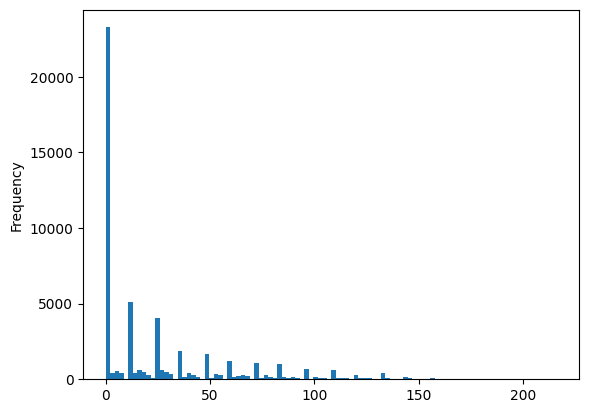

In [21]:
# Meh...
gdf_group["days_delta"].plot.hist(bins=100)

In [22]:
# 1 hectare = 10,000 m²
gdf_group["area_ha"] = gdf_group.area / 10000
gdf_group

,geometry,date_min,date_max,days_delta,clear_cut_group_size,area_ha
clear_cut_group,,,,,,
0,"MULTIPOLYGON (((756393.134 7150104.698, 756393...",2024-05-05,2024-05-05,0,2,0.033816
1,"POLYGON ((756402.53 7150003.664, 756402.53 715...",2024-04-11,2024-04-11,0,1,0.008454
2,"POLYGON ((758885.15 7147693.575, 758885.15 714...",2024-05-29,2024-05-29,0,1,0.008458
3,"POLYGON ((759144.616 7147676.13, 759152.979 71...",2024-06-22,2024-07-04,12,2,0.033829
4,"MULTIPOLYGON (((759003.422 7147583.601, 759003...",2024-05-29,2024-05-29,0,2,0.016915
...,...,...,...,...,...,...
51461,"POLYGON ((1234269.783 6023822.38, 1234269.783 ...",2024-01-16,2024-01-28,12,3,0.081619
51462,"POLYGON ((1228757.896 6022793.023, 1228757.896...",2024-01-22,2024-01-22,0,1,0.163252
51463,"POLYGON ((1228910.126 6022663.322, 1228910.126...",2024-08-01,2024-08-01,0,1,0.030611


In [23]:
gdf_group = gdf_group.sort_values("area_ha")
gdf_group

,geometry,date_min,date_max,days_delta,clear_cut_group_size,area_ha
clear_cut_group,,,,,,
1,"POLYGON ((756402.53 7150003.664, 756402.53 715...",2024-04-11,2024-04-11,0,1,0.008454
2,"POLYGON ((758885.15 7147693.575, 758885.15 714...",2024-05-29,2024-05-29,0,1,0.008458
7,"POLYGON ((757556.913 7146739.061, 757556.913 7...",2024-06-10,2024-06-10,0,1,0.008459
15,"POLYGON ((731591.933 7139501.403, 731591.933 7...",2024-06-22,2024-06-22,0,1,0.008469
17,"POLYGON ((755399.484 7139163.342, 755399.484 7...",2024-03-06,2024-03-06,0,1,0.008469
...,...,...,...,...,...,...
34238,"MULTIPOLYGON (((368631.052 6396178.685, 368629...",2024-01-12,2024-08-03,204,493,35.142598
42312,"POLYGON ((424668.593 6344976.607, 424668.593 6...",2024-03-24,2024-08-03,132,321,38.320393
33777,"MULTIPOLYGON (((400459.673 6398666.976, 400450...",2024-02-05,2024-08-03,180,530,44.457672


### An example where grouping works well!


In [50]:
def load_raster_subset(
    raster_path: str,
    minx: float,
    maxx: float,
    miny: float,
    maxy: float,
    min_date: pd.Timestamp | None = None,
) -> tuple[NDArray[np.floating], tuple[float]]:
    # Load a subset of a raster file based on given bounds.
    with rasterio.open(raster_path) as src:
        window = from_bounds(
            left=minx, bottom=miny, right=maxx, top=maxy, transform=src.transform
        )
        data = src.read(1, window=window)

        # Get updated transform for the subset
        transform = src.window_transform(window)

    # Remove dates prior to min_date
    if min_date:
        data[data < (min_date - SUFOSAT_START_DATE).days] = src.nodata

    # Prepare data for plotting
    data = data.astype(float)
    data[data == 0] = np.nan

    # Compute extent for imshow
    left, top = transform * (0, 0)  # Upper-left corner in world coordinates
    right, bottom = transform * (data.shape[1], data.shape[0])  # Lower-right corner
    extent = (left, right, bottom, top)
    print(extent)
    return data, extent


def plot_raster(
    data: NDArray[np.floating], extent: tuple[float], clear_cut: gpd.GeoDataFrame
) -> None:
    # Set up color mapping
    categories_thresholds = np.unique(data[~np.isnan(data)])
    if len(categories_thresholds) < 2:
        categories_thresholds = np.array(
            [categories_thresholds[0] - 1, categories_thresholds[0] + 1]
        )
    # Use the recommended way to get colormap
    cmap = plt.colormaps["viridis"].resampled(len(categories_thresholds))
    norm = BoundaryNorm(boundaries=categories_thresholds, ncolors=len(categories_thresholds))

    # Create plot
    fig, ax = plt.subplots()
    img = ax.imshow(data, cmap=cmap, norm=norm, extent=extent)

    # Configure colorbar with dates
    cbar = plt.colorbar(img)
    tick_values = cbar.get_ticks()
    tick_labels = [
        (SUFOSAT_START_DATE + pd.Timedelta(days=int(tick))).strftime("%Y-%m-%d")
        for tick in tick_values
    ]

    cbar.set_ticks(tick_values)
    cbar.set_ticklabels(tick_labels)
    cbar.set_label("Date")

    # Plot the clear cut polygon
    clear_cut.to_crs(epsg=4326).plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1)

    plt.title("Clear cut with multiple dates")
    plt.show()


def plot_example(gdf_group: gpd.GeoDataFrame, example_id: int) -> None:
    clear_cut = gdf_group.loc[[example_id]]

    # See for yourself with Sentinel 2 images
    long = clear_cut.centroid.to_crs(epsg=4326).iloc[0].x
    lat = clear_cut.centroid.to_crs(epsg=4326).iloc[0].y
    print(f"https://browser.dataspace.copernicus.eu/?zoom=17&lat={lat}&lng={long}")
    print(f"https://www.google.com/maps?q={lat},{long}")

    # Clear cut area
    print(str(int(clear_cut.area.iloc[0] / 10000)) + " hectares clear cut")

    # Plot the raster data (maybe we could overlay both in one plot)
    minx, miny, maxx, maxy = clear_cut.to_crs(epsg=4326).geometry.bounds.iloc[0].tolist()
    data, extent = load_raster_subset(
        raster_path="../data/sufosat/mosaics_tropisco_warnings_france_date.tif",
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        min_date=pd.Timestamp(year=2024, month=1, day=1),
    )
    plot_raster(data, extent, clear_cut)

https://browser.dataspace.copernicus.eu/?zoom=17&lat=44.62325182008097&lng=-0.7731936266565838
https://www.google.com/maps?q=44.62325182008097,-0.7731936266565838
44 hectares clear cut
(np.float64(-0.7781456631782495), np.float64(-0.7690339007836599), np.float64(44.61761959544384), np.float64(44.62885826228384))


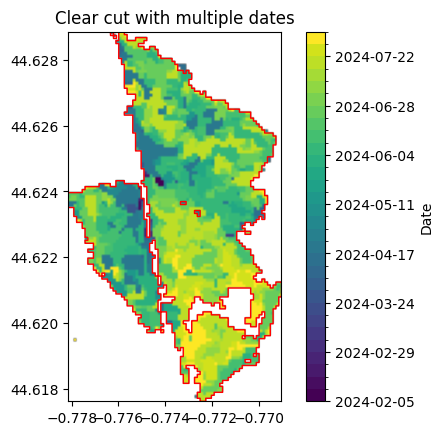

In [51]:
plot_example(gdf_group, 33777)

### An example that doesn't work well :(


https://browser.dataspace.copernicus.eu/?zoom=17&lat=44.56358317044714&lng=-1.1928271617886923
https://www.google.com/maps?q=44.56358317044714,-1.1928271617886923
176 hectares clear cut
(np.float64(-1.2141914504441438), np.float64(-1.171150362290753), np.float64(44.548193637370304), np.float64(44.575837132420304))


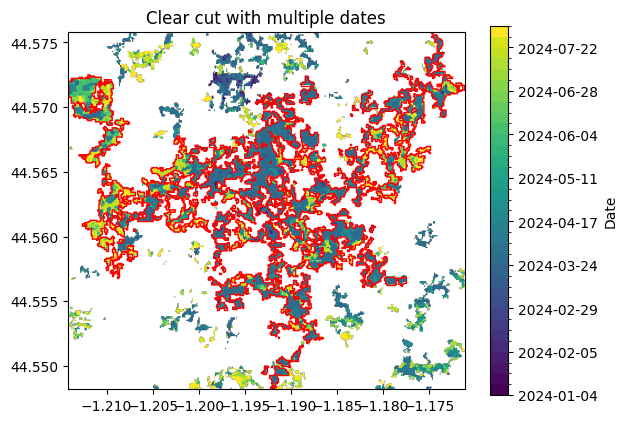

In [52]:
plot_example(gdf_group, 34737)

### Random examples of clear cuts >= 2 hectares


ID = 43559
https://browser.dataspace.copernicus.eu/?zoom=17&lat=44.08466912199148&lng=-0.2959497436611782
https://www.google.com/maps?q=44.08466912199148,-0.2959497436611782
10 hectares clear cut
(np.float64(-0.3019361864351042), np.float64(-0.2922249659882389), np.float64(44.08287657641762), np.float64(44.08668322163762))


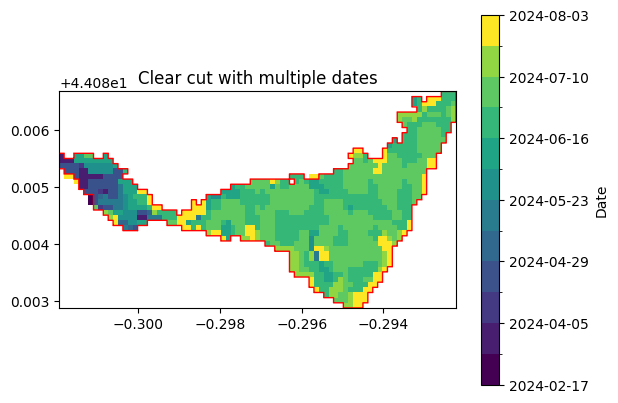

ID = 39643
https://browser.dataspace.copernicus.eu/?zoom=17&lat=44.31586895979628&lng=0.009127515739503623
https://www.google.com/maps?q=44.31586895979628,0.009127515739503623
15 hectares clear cut
(np.float64(0.004866444711014495), np.float64(0.014337881936969561), np.float64(44.31308797784367), np.float64(44.31789160157367))


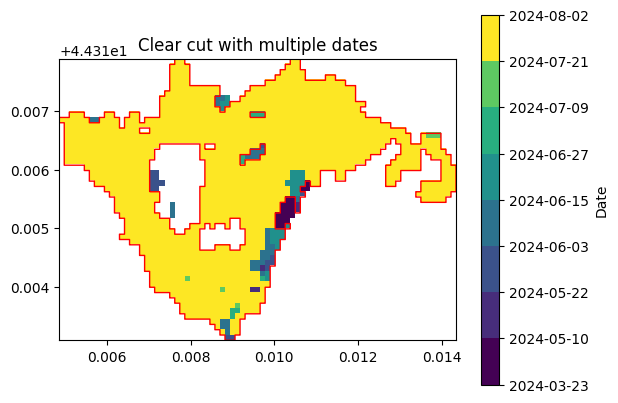

ID = 37020
https://browser.dataspace.copernicus.eu/?zoom=17&lat=44.46640286688754&lng=-0.5215955608077633
https://www.google.com/maps?q=44.46640286688754,-0.5215955608077633
12 hectares clear cut
(np.float64(-0.5248146903222555), np.float64(-0.5192996762413196), np.float64(44.46236285113721), np.float64(44.469704238347205))


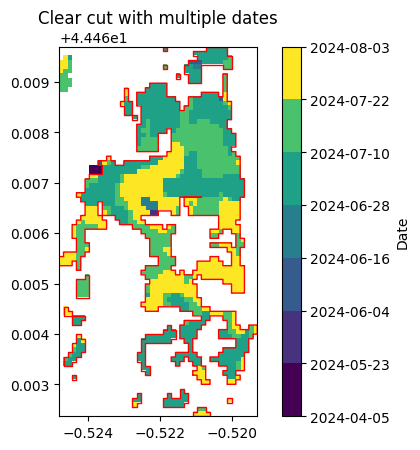

ID = 34634
https://browser.dataspace.copernicus.eu/?zoom=17&lat=44.57453680610423&lng=-1.193426904196936
https://www.google.com/maps?q=44.57453680610423,-1.193426904196936
24 hectares clear cut
(np.float64(-1.198965215927581), np.float64(-1.1869760548820683), np.float64(44.56949272377278), np.float64(44.57946250887279))


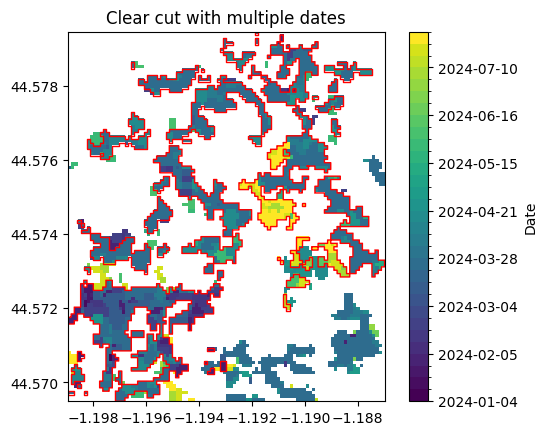

ID = 44505
https://browser.dataspace.copernicus.eu/?zoom=17&lat=44.009505844516326&lng=2.4135027932444637
https://www.google.com/maps?q=44.009505844516326,2.4135027932444637
15 hectares clear cut
(np.float64(2.411930307825373), np.float64(2.4154071645285717), np.float64(44.00375273651348), np.float64(44.01662282273349))


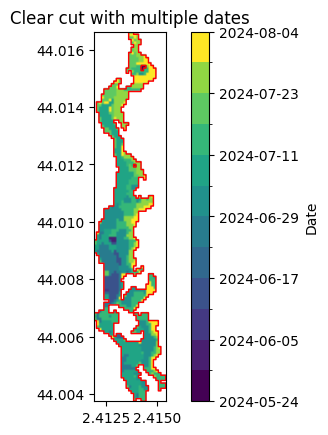

ID = 7460
https://browser.dataspace.copernicus.eu/?zoom=17&lat=48.24108152429087&lng=-4.283057493600928
https://www.google.com/maps?q=48.24108152429087,-4.283057493600928
10 hectares clear cut
(np.float64(-4.2878526677087425), np.float64(-4.277661880820057), np.float64(48.23900808144603), np.float64(48.24263345784603))


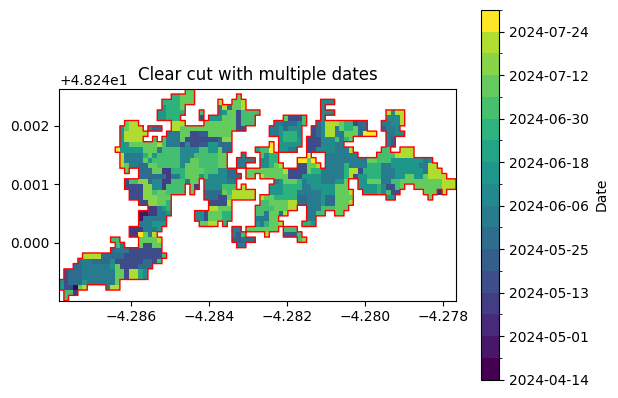

ID = 42201
https://browser.dataspace.copernicus.eu/?zoom=17&lat=44.159189148524995&lng=0.17100415660211093
https://www.google.com/maps?q=44.159189148524995,0.17100415660211093
12 hectares clear cut
(np.float64(0.16827870976484594), np.float64(0.17283459096214077), np.float64(44.156471717363566), np.float64(44.162091050783566))


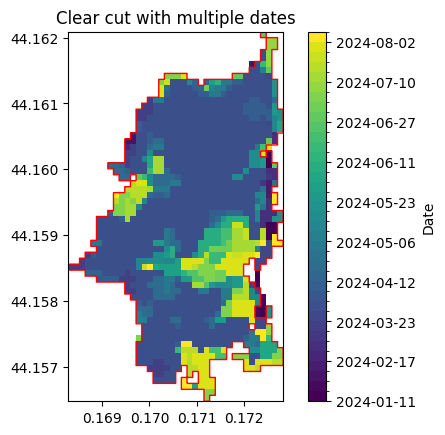

ID = 36613
https://browser.dataspace.copernicus.eu/?zoom=17&lat=44.48974740146341&lng=-0.9297743796835698
https://www.google.com/maps?q=44.48974740146341,-0.9297743796835698
10 hectares clear cut
(np.float64(-0.9344843232087161), np.float64(-0.9263316936977675), np.float64(44.48810302355377), np.float64(44.49181903436377))


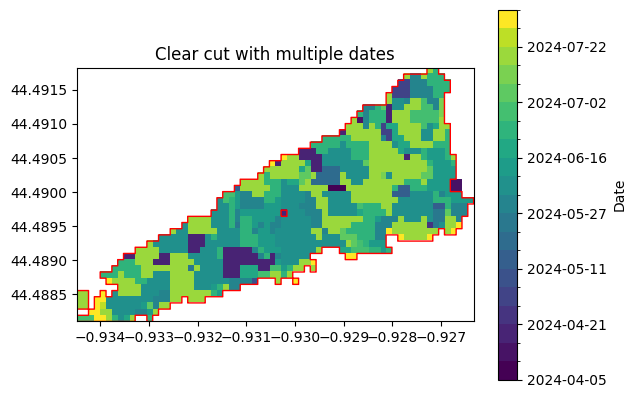

ID = 41691
https://browser.dataspace.copernicus.eu/?zoom=17&lat=44.188783268839884&lng=0.1860670193328974
https://www.google.com/maps?q=44.188783268839884,0.1860670193328974
24 hectares clear cut
(np.float64(0.18074743721861708), np.float64(0.19189735699094393), np.float64(44.18565599738946), np.float64(44.19227230931946))


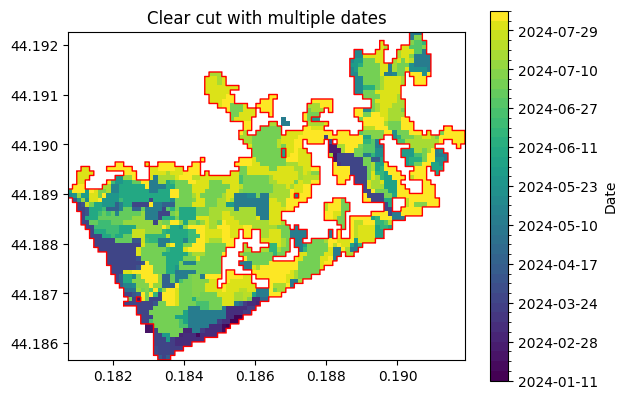

ID = 40388
https://browser.dataspace.copernicus.eu/?zoom=17&lat=44.26109422404916&lng=-0.4326778238833578
https://www.google.com/maps?q=44.26109422404916,-0.4326778238833578
17 hectares clear cut
(np.float64(-0.4351357656581252), np.float64(-0.428421835472638), np.float64(44.25562576190363), np.float64(44.26695506315363))


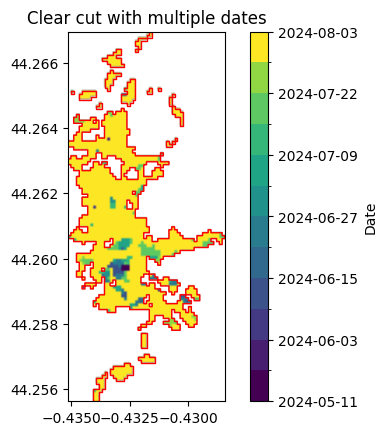

In [53]:
for example_id in gdf_group[gdf_group["area_ha"] >= 10].sample(10, random_state=42).index:
    print("ID =", example_id)
    plot_example(gdf_group, example_id)

## Upload result on S3


In [68]:
# No need to keep clear cuts < 0.5 ha
gdf_group = gdf_group[gdf_group["area_ha"] >= 0.5]
gdf_group

,date_min,date_max,days_delta,clear_cut_group_size,area_ha,geometry
clear_cut_group,,,,,,
51465,2024-04-21,2024-07-08,78,12,0.500123,"MULTIPOLYGON (((1242170.295 6021778.341, 12421..."
51454,2024-03-04,2024-04-21,48,19,1.386440,"MULTIPOLYGON (((1233121.944 6028390.495, 12331..."
51452,2024-06-20,2024-07-14,24,7,0.617602,"MULTIPOLYGON (((1198207.608 6067985.377, 11982..."
51373,2024-04-08,2024-07-25,108,51,2.102984,"MULTIPOLYGON (((1163543.691 6133084.278, 11635..."
51314,2024-05-26,2024-07-14,49,6,0.509373,"MULTIPOLYGON (((1188128.497 6151090.369, 11881..."
...,...,...,...,...,...,...
50082,2024-03-11,2024-07-09,120,25,1.072715,"MULTIPOLYGON (((313654.256 6235008.108, 313654..."
49979,2024-04-22,2024-07-27,96,23,1.159659,"MULTIPOLYGON (((315766.575 6243481.964, 315766..."
49905,2024-03-23,2024-06-03,72,18,0.863866,"MULTIPOLYGON (((315768.551 6250355.921, 315758..."


In [69]:
# Save the result to disk
gdf_group.to_file("../data/sufosat/sufosat_clear_cuts_2024.fgb")

In [70]:
# Upload to s3
!aws s3 cp ../data/sufosat/sufosat_clear_cuts_2024.fgb s3://brigade-coupe-rase-s3/analytics/data/sufosat/sufosat_clear_cuts_2024.fgb --profile d4g-s13-brigade-coupes-rases

upload: ../data/sufosat/sufosat_clear_cuts_2024.fgb to s3://brigade-coupe-rase-s3/analytics/data/sufosat/sufosat_clear_cuts_2024.fgb


In [71]:
!aws s3 ls s3://brigade-coupe-rase-s3/ --recursive --profile d4g-s13-brigade-coupes-rases

2025-02-18 21:53:57   32993275 analytics/data/ign/bdalti25/slope_gte_30.tif
2025-02-20 13:19:49  136122040 analytics/data/sufosat/sufosat_clear_cuts_2024.fgb
